# Lab 10: Fashion MNIST

---
author: Alejandra Arias
date: December 6, 2024
embed-resources: true
---

## Introduction

## Methods

In [5]:
# imports
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

# standard imports
import matplotlib.pyplot as plt
import numpy as np
import random

# sklearn data
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles
from sklearn.datasets import make_classification
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

# sklearn models
from sklearn.ensemble import RandomForestClassifier

# sklearn metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

# pytorch imports
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

### Data

In [2]:
# load data

# download training data from open datasets
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# download test data from open datasets
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26.4M/26.4M [01:08<00:00, 388kB/s] 


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 102kB/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:05<00:00, 812kB/s] 


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [3]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [20]:
# summary statistics
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [11]:
# visualizations
# get cpu, gpu or mps device for training
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device for training!")

Using cpu device for training!


### Models

In [41]:
# define batch size
batch_size = 64

# create train data loader
train_dataloader = DataLoader(
    training_data,
    batch_size=batch_size,
)

# create test data loader
test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size,
)

# check data shapes
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [36]:

# define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


# send model to compute device
model = NeuralNetwork().to(device)

# check model structure
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [37]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [38]:
# define train loop
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [39]:
# define test loop
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [43]:
# train model
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.587142  [   64/60000]
loss: 0.684800  [ 6464/60000]
loss: 0.469634  [12864/60000]
loss: 0.702026  [19264/60000]
loss: 0.635299  [25664/60000]
loss: 0.607768  [32064/60000]
loss: 0.654702  [38464/60000]
loss: 0.700093  [44864/60000]
loss: 0.687465  [51264/60000]
loss: 0.628154  [57664/60000]
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.629011 

Epoch 2
-------------------------------
loss: 0.571699  [   64/60000]
loss: 0.669896  [ 6464/60000]
loss: 0.457732  [12864/60000]
loss: 0.691034  [19264/60000]
loss: 0.627558  [25664/60000]
loss: 0.599772  [32064/60000]
loss: 0.641573  [38464/60000]
loss: 0.693417  [44864/60000]
loss: 0.680301  [51264/60000]
loss: 0.617719  [57664/60000]
Test Error: 
 Accuracy: 78.2%, Avg loss: 0.618596 

Epoch 3
-------------------------------
loss: 0.557627  [   64/60000]
loss: 0.656138  [ 6464/60000]
loss: 0.446768  [12864/60000]
loss: 0.680701  [19264/60000]
loss: 0.620416  [25664/60000]
loss: 0.592572  [32064/600

## Results

In [21]:
# report model metrics
# convert to TorchScript
model_scripted = torch.jit.script(model)

# write to disk
model_scripted.save("fashion-mnist.pt")

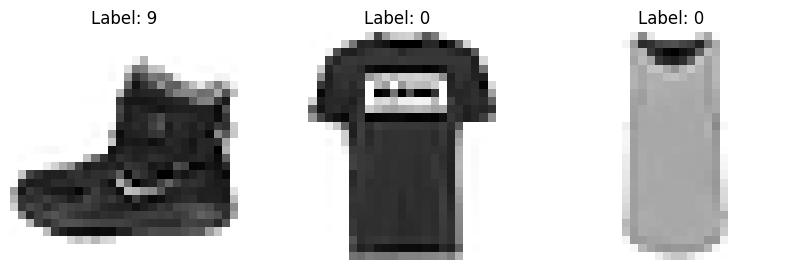

In [27]:
# get a batch of training data
batch = next(iter(train_dataloader))
images, labels = batch

# plot the first three images in the batch
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
for i in range(3):
    axs[i].set_axis_off()
    axs[i].imshow(images[i].squeeze(), cmap=plt.cm.gray_r)
    axs[i].set_title(f"Label: {labels[i]}")
plt.show()

## Discussion

### Conclusion